# Dimensionality Reduction with PCA
[Dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) is the process of reducing the number of random variables (features) under consideration while minimizing information loss in our data. The process of dimensionality reduction has a variety of applications and is used throughout the domain of data mining. Here we will explore the concepts behind [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis), and step through a couple of examples. 
- The first example is the canonical PCA example.
- We will examine the handwritten digits dataset, specifically clustering by principal components.
- We'll implement PCA on the Iris dataset.
- More interestingly, we'll try out PCA for facial recognition on the [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) dataset.

### Learning Goals
- Perform [***PCA with sklearn***](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- Use PCA as a precursor for clustering algorithms
- Use PCA as a precursor for classification algorithms
- Understand the output of ***PCA*** in terms of ***reduced features*** and ***explained variance***
- Use PCA as dimensionality reduction for a face recognition (classification) problem

### Datasets
- Random Manufactured: a 2-dimensional randomly sampled gaussian
- [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set): the familiar flower type classification dataset
- [Handwritten Digits Dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html): `sklearn`'s built-in handwritten digits dataset
- [Labeled Faces in the Wild Dataset](http://vis-www.cs.umass.edu/lfw/): Collection of headshot photographs of well-known people

In [1]:
import numpy as np
import pandas as pd

from sklearn import datasets, random_projection 
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image

/Users/foster/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## PCA Example - Random Data
### Make a random dataset
We'll generate a dataset from a randomly sampled 2-D Gaussian distribution of known mean and covariance matrix so we can demonstrate and visualize some of the principles (pun intended) of PCA.

In [2]:
# Specify a covariance matrix with x-variance 2.9, y-variance 6.5, and x-y covariance -2.2
cov = np.array([[2.9, -2.2], [-2.2, 6.5]])
print 'cov: \n{}'.format(cov)

#Make a random set of data (drawing from a multivariate normal distribution)
#Get 2-dimensional data with 500 rows (500X2 matrix)
#The mean of the distribution is [1,2]
#Covariance matrix of the distribution is cov
norm_dist = np.random.multivariate_normal([1,2], cov, size=500)  
print 'norm_dist: \n{}...'.format(norm_dist[:10])

cov: 
[[ 2.9 -2.2]
 [-2.2  6.5]]
norm_dist: 
[[ 2.92829355  3.3126562 ]
 [ 2.66862758 -0.95550782]
 [ 1.62569105  1.20052436]
 [-0.31596432  4.64183255]
 [ 0.4448727  -0.44979714]
 [ 0.2009335  -0.01470223]
 [ 1.17743314 -2.9716316 ]
 [ 1.14506688  3.75452129]
 [-1.02649262  0.95413556]
 [ 0.4956941  -0.96658269]]...


In [3]:
# check if norm_dist has approximately the expected sample mean and covariance
print 'mean: \n{}'.format(np.mean(norm_dist, axis=0))
print 'covariance: \n{}'.format(np.cov(norm_dist.T))

mean: 
[ 1.00078654  2.13712755]
covariance: 
[[ 3.05920235 -2.44312984]
 [-2.44312984  6.71523533]]


### Plot the Data
Let's try plotting our data to take a look at it.  Based on the gaussian parameters we set, the data should be centered near [1,2], should vary more in the y direction than the x direction (from the y and x variances), and there should be a negative correlation between x and y (from the negative covariance coefficient).

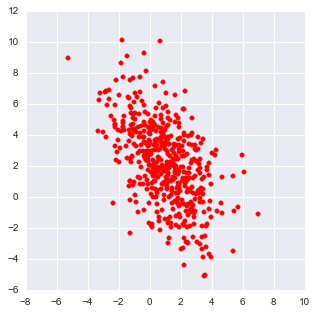

In [4]:
# Generate a single figure to hold our plot
fig = plt.figure(figsize=(5,5))
# Create the axes for our single plot
ax = fig.add_subplot(1,1,1)
# Generate a scatter plot of the x and y values of our data in red
ax.scatter(norm_dist[:,0], norm_dist[:,1], color='r')
ax.axis('equal') # equal scaling on both axis;

Does the data look as you expect?  Can you predict graphically where the first and second principal components might be (the directions along which the data varies most and 2nd most)?

### We would now like to analyze the directions in which the data varies most. 

##### For that, we place the point cloud in the center (0,0) and rotate a line through the data, such that the direction with most variance is parallel to the x-axis. Each succeding component in turn accounts for the highest variance possible that is orthoganal to existing components.

Now, let's perform principal component analysis (PCA) to project the data into fewer dimensions. In PCA, the projection is defined by principal components (eigenvectors), each of which can be viewed as a linear combination of the original features that corresponds to a dimension in the projection. The projection is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to (i.e., uncorrelated with) the preceding components. **Each principal component (eigenvector) is associated with an eigenvalue, which corresponds to the amount of the variance explained by that component.**

**Dimensionality reduction is a one-way transformation that induces a loss of information.** We can try to minimize the loss of information while retaining the benefits of dimensionality reduction by trying to find the number of principal components needed to effectively represent the original dataset. This number can often be determined by the "elbow" or "knee" point, which is considered to be the natural break between the useful principal components (or dimensions) and residual noise. We can find the elbow point by computing PCA on our dataset and observing the number of principal components after which the amount of variance explained displays a natural break or drop-off.

### Principal Components
We'll use the [`sklearn.decomposition.PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) object type to create an object that can perform PCA with the specified number of components.  Here we'll use `n_components=2` to examine the first 2 principal components, then we'll call `fit_transform()` on our data to transform our data into our new 2-dimensional space.

In [5]:
# Create the PCA-generator so it will retain 2 principal components
pca = PCA(n_components=2)
# Transform the data into our 2-D PCA space
norm_dist_pca = pca.fit_transform(norm_dist)

Let's check out the resulting eigenvectors from our decomposition.  To do this we will call `pca.components_` which returns an array of 2 (for 2 principal components) 2D vectors (for the original 2D space) which represent the linear coefficients that transform the original space into the PCA space.

In [6]:
# Retrieve and print the eigenvectors
eigvecs = pca.components_
print eigvecs

[[-0.44772133  0.89417315]
 [ 0.89417315  0.44772133]]


## Explore the data
Let's generate a few plots to demonstrate what the PCA is actually doing and provide some intuition.  We'll plot the 1st and 2nd principal components overlaying the original data in the original data space.  Then we'll plot the data in 1-D along both the 1st and 2nd principal components.  Finally we'll plot the data in the full transformed 2-D PCA space.

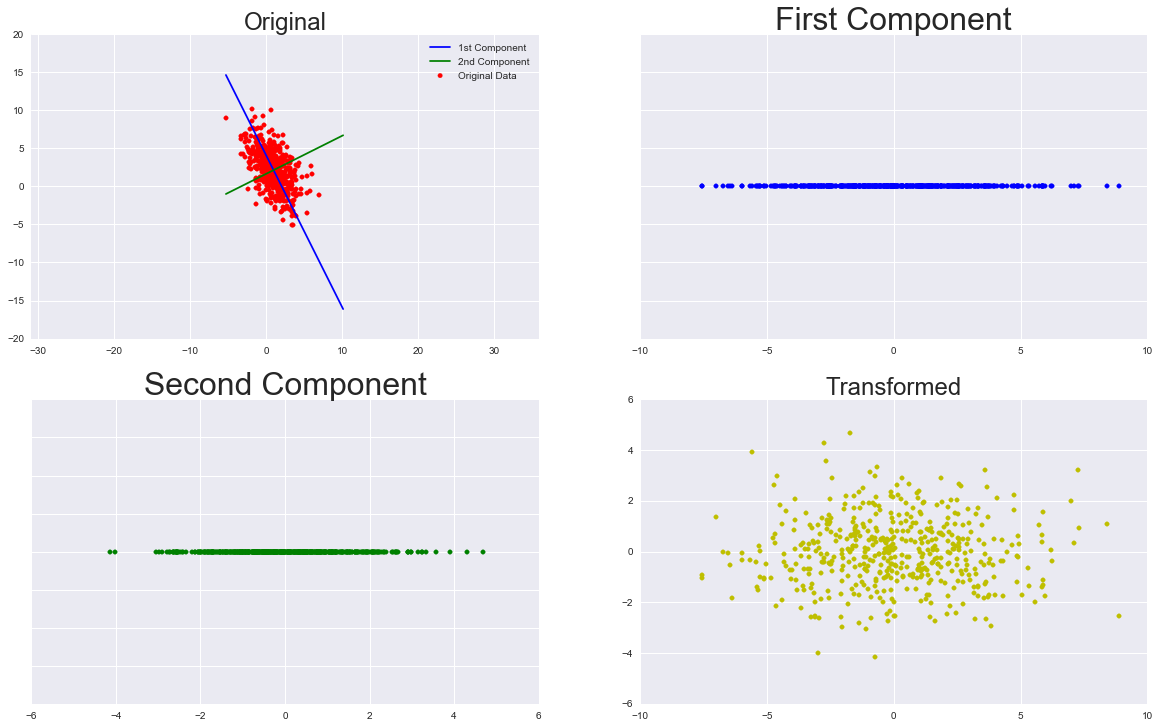

In [7]:
# Generate a figure to hold our plots
fig = plt.figure(figsize=(20,12))
# Create axes for the first plot, the original data with the principal component axes overlaid
ax = fig.add_subplot(2,2,1)
# Generate a scatter plot of the original data in red
ax.scatter(norm_dist[:,0], norm_dist[:,1], color='r', label='Original Data')
# Generate x-values that range over the original dataset
x = np.linspace(norm_dist.min(), norm_dist.max())
# Store the sample mean of the original data
x_mean = norm_dist.mean(0)[0]
y_mean = norm_dist.mean(0)[1]
# Generate equations for the 1st and 2nd principal component axes using point-slope form of a line going thru the mean
y1 = eigvecs[0][1]*(x-x_mean)/eigvecs[0][0] + y_mean
y2 = eigvecs[1][1]*(x-x_mean)/eigvecs[1][0] + y_mean
# Plot the 1st and 2nd principal component axes over the original data
# 1st component in blue, 2nd in green
ax.plot(x, y1, color='b', label='1st Component')
ax.plot(x, y2, color='g', label='2nd Component')
ax.legend()
ax.axis('equal') # equal scaling on both axis;
ax.set_title('Original', size=24)

# Create axes for the 2nd plot, which will show the points along only the 1st PCA axis
ax = fig.add_subplot(2,2,2)
# Plot the scatter plot along this axis
ax.scatter(norm_dist_pca[:,0], [1 for x in norm_dist_pca[:,0]], color='b')
ax.set_title('First Component', size=32)
ax.set_yticklabels([])
#ax.set_ylim()

# Create axes for the 3rd plot, which will show the points along only the 2nd PCA axis
ax = fig.add_subplot(2, 2, 3)
# Plot the scatter plot along this axis
ax.scatter(norm_dist_pca[:,1], [1 for x in norm_dist_pca[:,1]], color='g')
ax.set_title('Second Component', size=32)
ax.set_yticklabels([])

# Create axes for the 4th plot, which will plot the data in the full PCA space
ax = fig.add_subplot(2,2,4)
#Fill this part in with the transformed data
ax.scatter(norm_dist_pca[:,0], norm_dist_pca[:,1], color='y')
ax.axis('equal') # equal scaling on both axis;
ax.set_title('Transformed', size=24)

##### Questions:
- What do you notice about these plots?  
- Do the orientations of the PCA axes make sense to you?
- How many total PCA components could there be with this dataset?

Notice that the PCA axes are perpendicular (orthogonal), a requirement since the PCA eigenvectors form an orthogonal basis.

#### How much of the dataset's variation is explained by each component?
Let's use the `pca.explained_variance_ratio_` to print out how much variance is explained by each principal component.

In [8]:
print pca.explained_variance_ratio_

[ 0.81217302  0.18782698]


##### Questions:
- What percentage of the variance in the original data is explained by the first/second Principal Components?
- Does the total variance explained by the 2 combined make sense to you?

## Iris Dataset

Let's get introduced to PCA in `sklearn` with our friendly Iris dataset.  Load the dataset by a call to `sklearn.datasets.load_iris()`.  Store the results as `iris`.

In [9]:
# Load the iris data into iris
import sklearn
iris = sklearn.datasets.load_iris()

Store the iris data as `X` and center it (subtract the mean) into a variable called `X_centered`.

In [10]:
# get X
X = iris.data

# Center the data and store in X_centered
X_centered = X - X.mean(axis=0)

Perform a PCA on `X_centered` with 2 principal components by first creating a `PCA` object with `n_components=2` and then calling `fit_transform()` on `X_centered`.  Store the results in `X_pca`.

In [11]:
# Perform PCA with the first two components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_centered)

Now we'll try plotting the situation in our 2-D PCA space using the below plotting function.

In [12]:
#Useful plotting function
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle('rgbcmykw')
    target_ids = range(len(target_names))
    plt.figure()
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label)
    plt.legend()

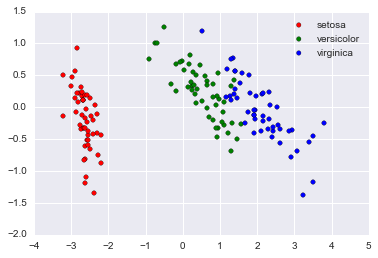

In [13]:
# add your transformed X and plot
plot_PCA_2D(X_pca, target=iris.target, target_names=iris.target_names)

What observations can you make?

#### Alternate PCA or Other Techniques
Try using a `sklearn.decomposition.RandomizedPCA` instead to perform the same 3 steps (create PCA, fit PCA, plot results in 2D).  Feel free to try out any of the other dimensionality reduction techniques in `sklearn` as well if you like.

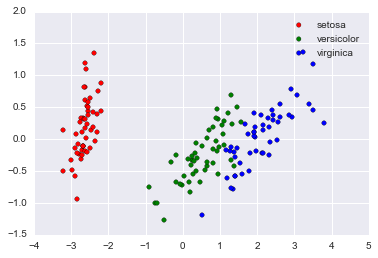

In [14]:
# Exercise 1: If you finish try running the above with a randomized PCA
from sklearn.decomposition import RandomizedPCA
rpca = RandomizedPCA()
X_rpca = rpca.fit_transform(X_centered)
plot_PCA_2D(X_rpca, target=iris.target, target_names=iris.target_names)

## Handwritten Digits
Now let's try using PCA to better explore our familiar handwritten digits dataset.

### Load the Data
Use a call to [`sklearn.datasets.load_digits()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) to load the digits dataset into a variable called `digits` with only the digits 0-5 (`n_class=6`).

In [15]:
# load the dataset with 6 classes (digits 0 through 5)
digits = sklearn.datasets.load_digits(n_class=6)

Use a `pd.DataFrame()` and `pd.Series()` constructor to convert the feature and target data from `digits` into a dataframe `X` and a series `y` respectively.

In [16]:
# load the explanatory (or independent or feature) variables into a dataframe X
X = pd.DataFrame(digits.data)

# load the target (or dependent or class) variable into a series y
y = pd.Series(digits.target)

Check out the shape of the data matrix `X` by a call to shape just to make sure the number of samples and features is right.  Store the number of samples in `n_samples` and the number of features in `n_features`.

In [17]:
# print the number of rows (samples) and columns (features) with a call to shape
X.shape

(1083, 64)

### Explore the Data
Let's take a look at what some of our data actually looks like by printing out a number of images.

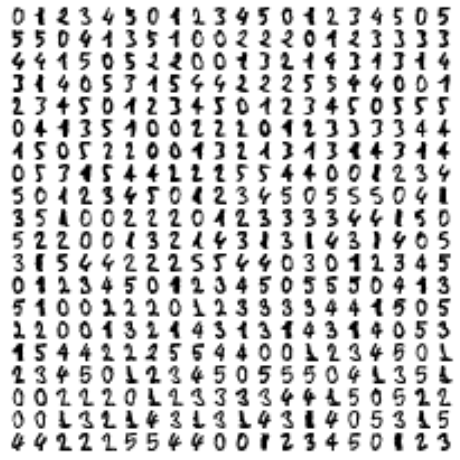

In [18]:
n_img_per_row = 20 # number of digits per row
img = np.zeros((10*n_img_per_row, 10*n_img_per_row)) # generate a new 200x200 array filled with zeros
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix+8, iy:iy+8] = X.ix[i*n_img_per_row + j].reshape((8, 8)) # set each 8x8 area of the img to the values of each row (reshaped from 1x64 to 8x8)

plt.figure(figsize=(8, 8), dpi=250) # define a figure, with size (width and height) and resolution
#axes(frameon = 0) # remove the frame/border from the axes
plt.imshow(img, cmap=plt.cm.binary) # show the image using a binary color map
plt.xticks([]) # no x ticks
plt.yticks([]) # no y ticks
print

### Data Standardization
Generally, PCA requires centering the data (i.e., subtracting the mean from each data point for each feature), because otherwise the first component may not truly describe the largest direction of variation in the data, but rather the mean of the data.

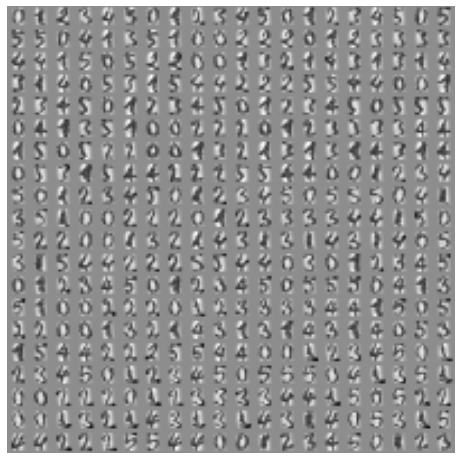

In [19]:
# global centering
X_centered = X - X.mean()

# print again
n_img_per_row = 20 # number of digits per row
img = np.zeros((10*n_img_per_row, 10*n_img_per_row)) # generate a new 200x200 array filled with zeros
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix+8, iy:iy+8] = X_centered.ix[i*n_img_per_row + j].reshape((8, 8)) # set each 8x8 area of the img to the values of each row (reshaped from 1x64 to 8x8)

plt.figure(figsize=(8, 8), dpi=250) # define a figure, with size (width and height) and resolution
#axes(frameon = 0) # remove the frame/border from the axes
plt.imshow(img, cmap=plt.cm.binary) # show the image using a binary color map
plt.xticks([]) # no x ticks
plt.yticks([]) # no y ticks
print

### Perform PCA
Now let's generate a PCA on the digits data.  
- Create an object called `pca` that is a `sklearn.decomposition.PCA` object with `n_components=64` (we'll want to examine the different components later so keep all of the 64 possible principal components)
- Use `pca.fit_transform()` on our centered digit data `X_centered` to transform the digit data into the PCA space.  Store the result in `X_pca`

In [20]:
# Create PCA-generator
pca = PCA(n_components=64)
# Transform X_centered to X_pca via a fit_transform
X_pca = pca.fit_transform(X_centered)

### Evaluate Results
Now that we have a PCA we can examine the different components.  Let's try to make a bar plot of the variance explained (proportion) for each principal component.

(1083, 64)


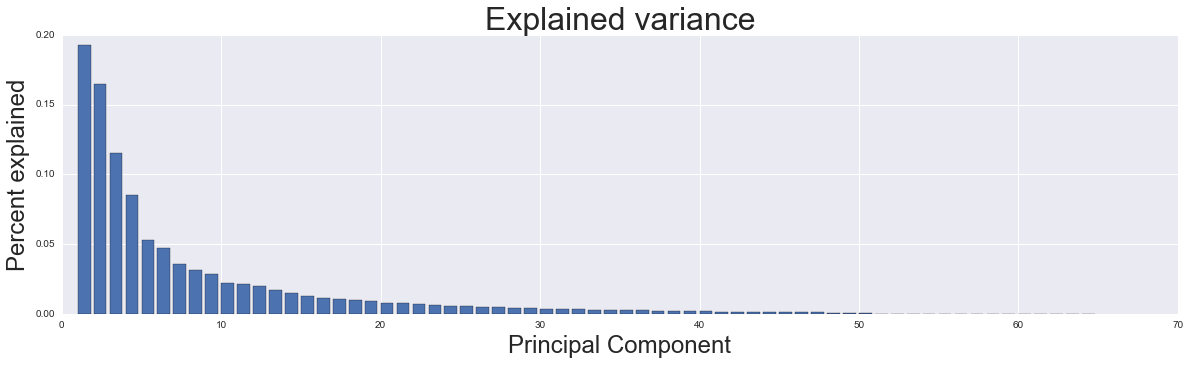

In [21]:
# Generate a figure with figsize=(20,5)
fig = plt.figure(figsize=(20,5))

# Generate axes via add_subplot
ax = fig.add_subplot(1,1,1)

# Call ax.bar on the appropriate x and y to generate a bar graph of the explained variance for each component
# x should be the numbers 1 to 64
# y should be pca.explained_variance_ratio_
x = range(1,65)
y = pca.explained_variance_ratio_

ax.bar(left=x, height=y)

ax.set_title("Explained variance", size=32)
ax.set_ylabel("Percent explained", size=24)
ax.set_xlabel("Principal Component", size=24);
print X_centered.shape

##### Questions
- What do you notice?
- How many principal components do you think you might retain?

Dimensionality reduction is a one-way transformation that induces a loss of information. We can try to minimize the loss of information while retaining the benefits of dimensionality reduction by trying to find the number of principal components needed to effectively represent the original dataset. This number can often be determined by the "elbow" or "knee" point, which is considered to be the natural break between the useful principal components (or dimensions) and residual noise. We can find the elbow point by computing PCA on our dataset and observing the number of principal components after which the amount of variance explained displays a natural break or drop-off.

#### Optional: Try Printing the first 10 "Eigendigits" in the same spirit as the "Eigenfaces" in the LFW Exercise below
Don't do this part right now, but feel free to come back and try it after you've completed the Labeled Faces in the Wild facial recognition exercise later in this notebook.  Use similar techniques as the eigenfaces to print out the eigendigits.

(64, 64)
(64, 8, 8)


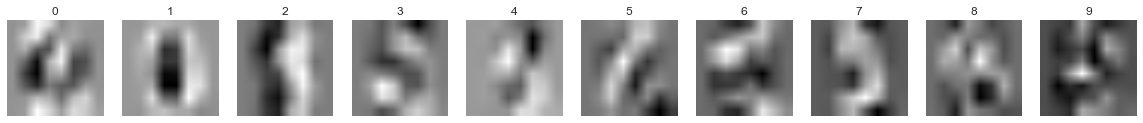

In [22]:
# Use components_ and reshape to get a 64x8x8 array of eigendigits
print pca.components_.shape
eigendigits = np.resize(pca.components_, [64, 8, 8])
print eigendigits.shape

# Generate a figure with figsize=(16,160)
fig = plt.figure(figsize=(16, 160))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

# For 0-9, print out the corresponding eigendigit in a subplot
n_rows = 1
n_cols = 10
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(eigendigits[i].reshape((8, 8)), cmap=plt.cm.gray)
    plt.title(i)
    plt.xticks(())
    plt.yticks(())


#### Lets look at the first 2 components:
Looking at only the first 2 components allows us to make actually visualize our dataset in 2-D to the best level that we can.  Use whatever method you like to determine how much variance is explained by the first 2 components in the digits PCA (**HINT:** use `explained_variance_ratio_`).

In [23]:
# I don't know what the following comment means:
#It's easy to represent 2 elements in a plot
print sum(pca.explained_variance_ratio_[0:2])


0.357601743362


What we're going to do in the next few steps is visualize how the different digits cluster in just 2 dimensions in our 2-D PCA space.  We'll start with a function `plot_embedding` which takes data and plots the digits in the 2-D space where the point is actually rendered as the digit itself.

First we'll call this function on data randomly projected into 2-D from the original space and then on the PCA 2-D projection.  You should notice how well the PCA projection separates out the different classes even with just the first 2 components.

In [24]:
def plot_embedding(X, title=None):
    # min-max normalization
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(10, 6), dpi=250)
    ax = plt.subplot(111)
    ax.axis('off')
    ax.patch.set_visible(False)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]), color=plt.cm.Set1(y[i] / 10.), fontdict={'weight': 'bold', 'size': 12})

    plt.xticks([]), plt.yticks([])
    plt.ylim([-0.1,1.1])
    plt.xlim([-0.1,1.1])

    if title is not None:
        plt.title(title, fontsize=16)

##### Random 2D Projection

IndexError: index 64 is out of bounds for axis 0 with size 64

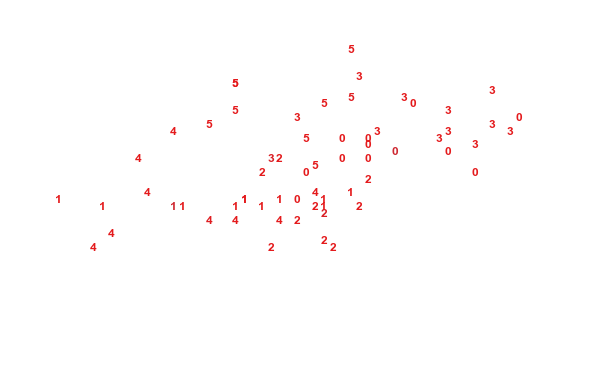

In [25]:
# Random 2D projection using a random unitary matrix

#print("Computing random projection"),
rp = random_projection.SparseRandomProjection(n_components=2, random_state=0)
X_projected = rp.fit_transform(X)
#print("done.")

# Plot random projection result
plot_embedding(X_projected, "Random Projection of the Digits Dataset\n")

##### PCA Projection

IndexError: index 64 is out of bounds for axis 0 with size 64

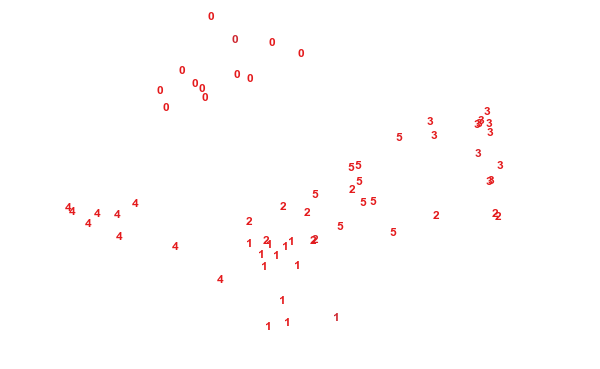

In [26]:
plot_embedding(X_pca, "2 components")

### This is unsupervised learning

- PCA has no information about the classes, but provides insight into the distribution of different numbers in the parameter space
- 0 and 4 tend to be more distinct then 1, 2, 5
- Does this make sense?

## Labeled Faces in the Wild Facial Recognition
The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

.. _LFW: http://vis-www.cs.umass.edu/lfw/

Expected results for the top 5 most represented people in the dataset::

|                       | precision | recall | F1  | support |
|-------------------    |-----------|--------|-----|---------|
| **Gerhard_Schroeder** | .91       | .75    | .82 | 28      |
| **Donald_Rumsfeld**   | .84       | .82    | .83 | 33      |
| **Tony_Blair**        | .65       | .82    | .73 | 34      |
| **Colin_Powell**      | .78       | .88    | .83 | 58      |
| **George_W_Bush**     | .93       | .86    | .90 | 128     |
| **avg / total**       | .86       | .84    | .85 | 282     |

Our goal will be to build a classifier that successfully recognizes new images of the top 7 most frequently occurring people (these 5 plus 2 more) as the appropriate person.  We'll first run a PCA to reduce the dimensionality of the image space, and then use whatever classifier you like on the resulting PCA space to generate the classification predictions.

In [6]:
# Import necessary packages

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

### Load the Data
Use the function [`fetch_lfw_people()`](http://scikit-learn.org/stable/datasets/labeled_faces.html) to load in the labeled faces data.  Make sure to set `data_home`, `min_faces_per_person=70` and `resize=0.4`.  Store the result as `lfw_people`.

In [7]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

Use `shape` on `lfw_people.images` to get the number of images (store as `n_samples`), height (store as `h`), and width (store as `w`) of each image.

In [8]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
print "h %d" % h
print "w %d" % w

h 50
w 37


Store `lfw_people.data` into `X` and store the number of features in `X` a `n_features`.  What is `n_features`?

In [9]:
# Store the data in X
X = lfw_people.data
n_features = X.shape[1]

Store `lfw_people.target` into `y` and `lfw_people.target_names` into `target_names`.  Print each as well as the number of classes (store this as `n_classes`).

In [10]:
# Store targets in y
y = lfw_people.target

# Store target names in target_names
target_names = lfw_people.target_names

# Store number of classes in n_classes
n_classes = len(target_names)

In [11]:
print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


#### Generate Train/Test Set
Use `train_test_split()` to generate a 70/30 train/test split and store this in `X_train`, `X_test`, `y_train`, `y_test`.

In [12]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

### Generate the PCA
Use a `RandomizedPCA` to construct a PCA (store as `pca`) which keeps `n_components=150` principal components and call `fit()` on `X_train` with this `pca` to generate the mapping.

In [13]:
# Compute a PCA (eigenfaces) on the face dataset
# Keep 150 principal components
n_components = 150

print "Extracting the top %d eigenfaces from %d faces" % (
    n_components, X_train.shape[0])
t0 = time()
# Create a RandomizedPCA with n_components and fit it to X_train
rpca = RandomizedPCA(n_components=n_components,whiten=True)
rpca.fit(X_train)
print "done in %0.3fs" % (time() - t0)
print X_train.shape

Extracting the top 150 eigenfaces from 901 faces
done in 0.305s
(901, 1850)


Generate `X_train_pca` by calling the pca transformation (`transform()`) on `X_train` and likewise generate `X_test_pca` by calling it on `X_test`.  After this we will have reduced space feature vectors in our PCA space for both the training and test sets.

In [14]:
print "Projecting the input data on the eigenfaces orthonormal basis"
t0 = time()
# Transform X_train to X_train_pca
X_train_pca = rpca.transform(X_train)
# Transform X_test to X_test_pca
X_test_pca = rpca.transform(X_test)

print "done in %0.3fs" % (time() - t0)

Projecting the input data on the eigenfaces orthonormal basis
done in 0.036s


#### Plot this bad boy

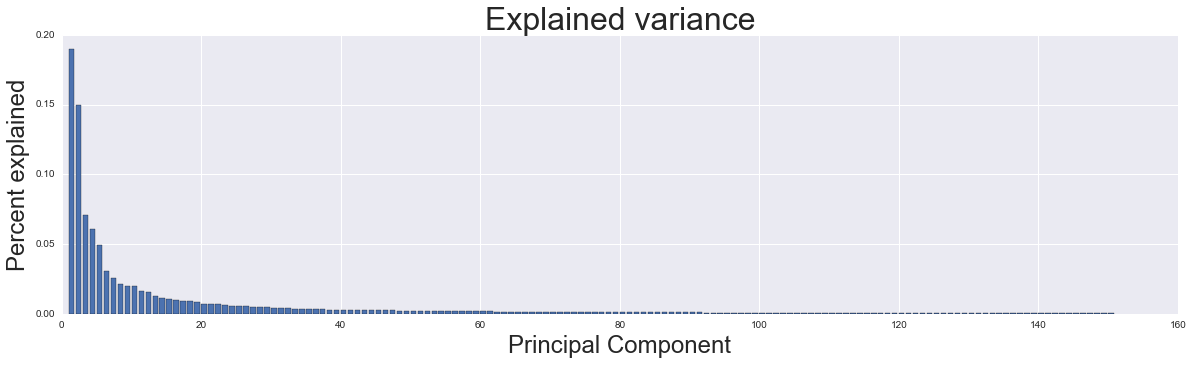

In [15]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Generate a figure with figsize=(20,5)
fig = plt.figure(figsize=(20,5))

# Generate axes via add_subplot
ax = fig.add_subplot(1,1,1)

# Call ax.bar on the appropriate x and y to generate a bar graph of the explained variance for each component
# x should be the numbers of components
# y should be rpca.explained_variance_ratio_
x = range(1,n_components + 1)
y = rpca.explained_variance_ratio_

ax.bar(left=x, height=y)

ax.set_title("Explained variance", size=32)
ax.set_ylabel("Percent explained", size=24)
ax.set_xlabel("Principal Component", size=24);


### Building a Classifier for Face Classification
Now that we have a reduced vector space for our features of both the training and test sets, we can try to build a classifier against that space which will be able to accurately classify images into one of the 7 person classes seen earlier.  

First let's try an RBF kernel SVM classifier, and let's try different parameters of `C` and `gamma` via `GridSearchCV`.  Generate a dict `param_grid` with possible values of `C` (1e3, 5e3, 1e4, 5e4, 1e5) and possible values of `gamma` (0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1).

In [16]:
# Generate a param_grid for GridSearchCV
param_grid = dict()
param_grid['C'] = [1e3, 5e3, 1e4, 5e4, 1e5]
param_grid['gamma'] = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]

Now train your SVM Classifier via `GridSearchCV`:
- Create a `GridSearchCV` called `clf` where the first parameter is a new `SVC` with an 'rbf' kernel and `class_weight='auto'`, and the second parameter is `param_grid`
- Call `fit()` on `clf` with `X_train_pca` and `y_train`

In [17]:
# Train a SVM classification model
print "Fitting the classifier to the training set"
t0 = time()
# Create GridSearchCV
clf = GridSearchCV(SVC(kernel='rbf', class_weight='auto'), param_grid)

# Fit the model
clf.fit(X_train_pca, y_train)

print "done in %0.3fs" % (time() - t0)
print "Best score:"
print clf.best_score_
print "Best estimator found by grid search:"
print clf.best_estimator_

Fitting the classifier to the training set
done in 14.535s
Best score:
0.783573806881
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='auto', coef0=0.0, degree=3,
  gamma=0.005, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)


### Evaluating Our Model Success
Now let's see how our model did:
- Generate predictions `y_pred` by calling `predict()` against `X_test_pca`
- Print out the `classification_report()` and `confusion_matrix()` for these predictions vs `y_test`

In [18]:
# Quantitative evaluation of the model quality on the test set

print "Predicting the people names on the testing set"
t0 = time()
# Generate test predictions as y_pred
y_pred = clf.predict(X_test_pca)

print "done in %0.3fs" % (time() - t0)
# Print classification_report
print "classification:"
print classification_report(y_test, y_pred, target_names=target_names)

# Print confusion_matrix
print "confusion:"
print confusion_matrix(y_test, y_pred)

Predicting the people names on the testing set
done in 0.080s
classification:
                   precision    recall  f1-score   support

     Ariel Sharon       0.84      0.76      0.80        21
     Colin Powell       0.78      0.89      0.83        63
  Donald Rumsfeld       1.00      0.68      0.81        41
    George W Bush       0.80      0.98      0.88       155
Gerhard Schroeder       0.97      0.76      0.85        41
      Hugo Chavez       1.00      0.52      0.69        23
       Tony Blair       0.97      0.79      0.87        43

      avg / total       0.87      0.85      0.85       387

confusion:
[[ 16   2   0   2   0   0   1]
 [  2  56   0   5   0   0   0]
 [  0   4  28   9   0   0   0]
 [  0   3   0 152   0   0   0]
 [  1   1   0   8  31   0   0]
 [  0   4   0   6   1  12   0]
 [  0   2   0   7   0   0  34]]


How did your model do?  Are you impressed with this performance?  Think you can do better?  If so, go ahead and try out some different models to see if you can improve.  Still, ~85% accuracy on this task without any sort of specific image processing feature detection going on is pretty impressive.

### Understanding Results: "Eigenfaces"
The eigenvectors aka principal components in this example essentially represent what we'll call "eigenfaces".  These are basically ghostly faces making up the basis of faces in the PCA space (every face can be expressed as some linear combination of these eigenfaces).  Like usual, the eigenfaces are ordered from greatest to least distinguishing power.  

The plot functions below will plot some of the first few eigenfaces, take a look and see if the results make sense to you.  Can you imagine why some results are happening?  Feel free to now try and implement a similar procedure for eigendigits back in the handwritten digits exercise from above.

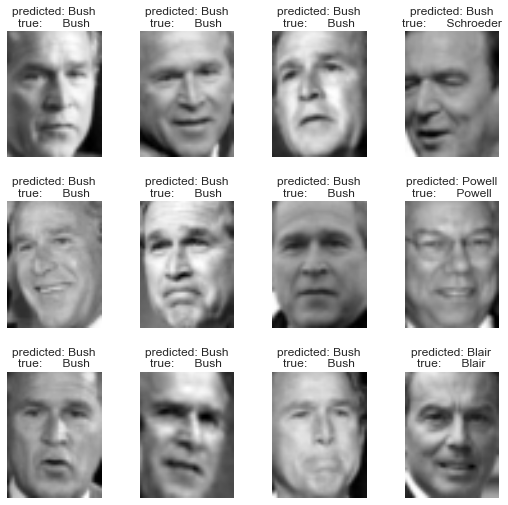

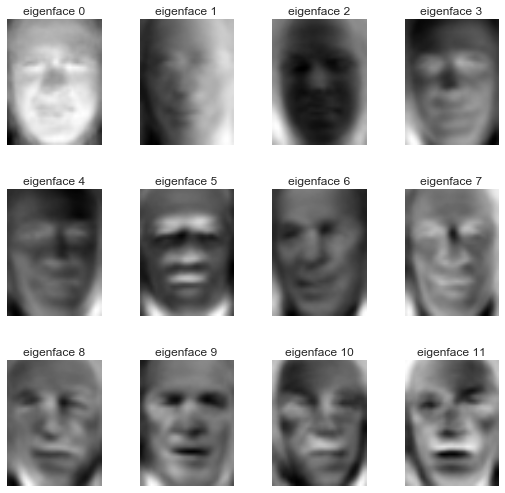

In [19]:
# Retrieve the eigenfaces
eigenfaces = rpca.components_.reshape((n_components, h, w))

# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significant eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()